<a href="https://colab.research.google.com/github/waltermayor/DigitalImageProcessing_colab/blob/master/MLP_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
#import keras as k
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image

% pip install opencv-contrib-python==3.2.0.7

In [0]:
def displayColor2(a, b,title1 = "Original", title2 = "Edited"):
    plt.figure(figsize=(20,20))
    plt.subplot(131), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [0]:
n_inputs = 32*32*3       # flattening each image to provide as input.  #  trying to form a model in the shape of a tunnel
n_hidden1 = 400        # Num of nodes in hidden layer 1.
n_hidden2 = 250        
n_hidden3 = 64
n_outputs = 10        # Number of final outputs

In [0]:
# Now declare the input and output placeholders. 
# Placeholders let us use different userdefined inputs in the first and last layers 

X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")  #The None values can be taken as i/p's from user later.
y = tf.placeholder(tf.int32, shape=(None), name = "y")
training = tf.placeholder_with_default(False, shape=(), name='training')


In [0]:
### This function is not used in the code below - It is just for personal reference.
def neural_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        std_dev = 2/np.sqrt(n_inputs)   # Inorder to not let the SGD algo break or explode, it is essential to initialize the 
                                        # variables. Initializing randomly using a truncated normal distribution with a 
                                        # std_dev of 2/ sqrt(n_inputs) can drastically improve the performance of the nn.
        init = tf.truncated_normal((n_inputs, n_neurons), stddev = std_dev)
        W = tf.Variable(init, name = "Kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name = "bias")
        Z = tf.matmul(X, W) + b;
        if activation is not None:
            return activation(Z)
        else:
            return Z

##Instead of this function we can use tensorflow inbuilt function - tf.layers.dense() to achieve the same purpose.

In [6]:
from functools import partial  # The batch normalization can be automated using "partial" - but i havent done that below

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

batch_norm_momentum = 0.9
with tf.name_scope("dnn"):
    
    #### Different initializers
    
    #he_init = tf.variance_scaling_initializer()  - around 45% acc (SGD)
    #he_init = tf.random_uniform_initializer()    - around 46.5% acc (SGD)
    he_init = tf.contrib.layers.xavier_initializer()  # - 48% accuracy (SGD) , upto 50% using Adam
    
    #### 3 Hidden layers, each using relu activation function

    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
    bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9) 
    # Momentum of 0.9 is best known for optimization.
    bn1Activation = tf.nn.relu(bn1)
    
    hidden2 = tf.layers.dense(bn1Activation, n_hidden2, name = "hidden2")
    bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
    bn2Activation = tf.nn.relu(bn2)

    hidden3 = tf.layers.dense(bn2Activation, n_hidden3, name = "hidden3")
    bn3 = tf.layers.batch_normalization(hidden3, training = training, momentum = 0.9)
    bn3Activation = tf.nn.relu(bn3)
    logits_before_bn = tf.layers.dense(bn3Activation, n_outputs, name = "outputs") 
    
    # NOTE:: logits are the nn outputs before classifying/ or activation layer
    #logits = tf.nn.softmax(my_batch_norm_layer(logits_before_bn))

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits =logits_before_bn)
    # "labels": vector must provide a single specific index for the true class
    
    # WARNING: This op expects unscaled logits, since it performs a softmax on logits internally for efficiency.
    # Do not call this op with the output of softmax, as it will produce incorrect results.
    loss = tf.reduce_mean(xentropy, name="loss")
    

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05, epsilon=1e-06, use_locking=True,name='Adam')
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits_before_bn, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [0]:
init = tf.global_variables_initializer()      #initializes the tf.variable/constant/placeholders declared above
#he_init = tf.contrib.layers.xavier_initializer()
saver = tf.train.Saver()                      # helps to save the model and reuse later.

In [8]:
### Now load the data
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)
[9]
[9]


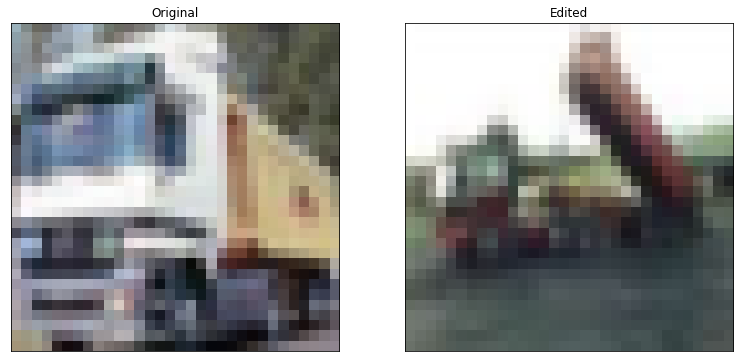

In [9]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)
print(y_train[1])
print(y_train[2])

displayColor2(X_train[1],X_train[2])

In [30]:

gray= cv2.cvtColor(X_train[7],cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
#kp = sift.detect(gray,None)
kp, des = sift.detectAndCompute(gray,None)
#gb = Image.fromarray(X_train[1])
img=cv2.drawKeypoints(gray,kp,outImage=np.array([]),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#displayColor2(X_train[1],img)
print(len(kp),len(des))
print(len(des[1]))

11 11
128


In [16]:
# Transforming label indices to one-hot encoded vectors 

## No need to convert to one hot now, we have done later in the code. 
## in tn.softmax_with_crossentropy_with_logits, the labels argument asks for the index of actual class. Therefore, we halt one
## hot encoding as of now.

#y_train = to_categorical(y_train, num_classes=10)
#y_test = to_categorical(y_test, num_classes=10)

# Transforming images from (32,32,3) to a single vector of size (32*32*3) {32*32*3 = 3072}

X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalization of pixel values (to [0-1] range) # converting uint8 to double format

X_train /= 255
X_test /= 255

ValueError: ignored

In [0]:
# Now divide the test and train datasets into 3 parts, training set, validation set, and testing set
# Considering the validation set to have 5000 images
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [16]:
print(X_train.shape, y_train.shape)     #Just to have a clear idea of the training/ validation/testing shapes of tensors
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(45000, 3072) (45000, 1)
(5000, 3072) (5000, 1)
(10000, 3072) (10000, 1)


In [0]:
n_epochs = 25
batch_size = 6000 
# If batch size is less like 100 or so, acc will fluctuate like 44% 20% 55% etc erratically due to underfitting nature

# A function to shuffle the whole data set and select different batches randomly with replacement.
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch                         # returns the first batch that was formed.
        
# Yeild is similar to return, the fun or loop runs untill it hits yeild, then what ever the first value of that variable is,
# at that moment, it gets returned, and the loop continues.

In [18]:
# Now lets test the model with the built model on Validation Set

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# tf.get_collection(), which can find some tensor that you want,
# UPDATE_OPS is a collection of ops (operations performed when the graph runs, like multiplication, ReLU, etc.), not variables. 
#y = tf.placeholder(tf.int32, shape=(None,10), name="y")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch.reshape([-1])})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid.reshape([-1])})
        print(epoch, "Validation accuracy:", accuracy_val)
        

0 Validation accuracy: 0.104
1 Validation accuracy: 0.092
2 Validation accuracy: 0.092
3 Validation accuracy: 0.1364
4 Validation accuracy: 0.1518
5 Validation accuracy: 0.1346
6 Validation accuracy: 0.1614
7 Validation accuracy: 0.1096
8 Validation accuracy: 0.0972
9 Validation accuracy: 0.092
10 Validation accuracy: 0.092
11 Validation accuracy: 0.092
12 Validation accuracy: 0.092
13 Validation accuracy: 0.092
14 Validation accuracy: 0.092
15 Validation accuracy: 0.092
16 Validation accuracy: 0.092
17 Validation accuracy: 0.0972
18 Validation accuracy: 0.092
19 Validation accuracy: 0.092
20 Validation accuracy: 0.092
21 Validation accuracy: 0.11
22 Validation accuracy: 0.092
23 Validation accuracy: 0.092
24 Validation accuracy: 0.096


In [19]:
# Once accuracy over validation set is satisfactory, test the results on test set

n_epochs = 25
batch_size = 5000

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch.reshape([-1])})
        if epoch % 2 == 0:
            accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test.reshape([-1])})
            print(epoch, "TestSet accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_cifar10_model_final.ckpt")


0 TestSet accuracy: 0.1
2 TestSet accuracy: 0.1
4 TestSet accuracy: 0.1
6 TestSet accuracy: 0.1108
8 TestSet accuracy: 0.1
10 TestSet accuracy: 0.1
12 TestSet accuracy: 0.1357
14 TestSet accuracy: 0.1008
16 TestSet accuracy: 0.1
18 TestSet accuracy: 0.1
20 TestSet accuracy: 0.1
22 TestSet accuracy: 0.1
24 TestSet accuracy: 0.1
